--- Step 1: Initialization ---
Using device: CUDA

--- Step 2: Loading Data ---
Classes found: ['brain_glioma', 'brain_menin', 'brain_tumor']
Dataset split: 10500 Train, 2250 Val, 2250 Test

--- Step 3: Setting up VGG16 ---


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--- Step 4: Training for 50 Epochs ---
Epoch 1/50 - Train Loss: 0.4405, Val Loss: 0.2691
  -> Best model saved!
Epoch 2/50 - Train Loss: 0.2869, Val Loss: 0.1928
  -> Best model saved!
Epoch 3/50 - Train Loss: 0.2703, Val Loss: 0.2294
Epoch 4/50 - Train Loss: 0.2706, Val Loss: 0.2080
Epoch 5/50 - Train Loss: 0.2745, Val Loss: 0.1880
  -> Best model saved!
Epoch 6/50 - Train Loss: 0.2342, Val Loss: 0.1916
Epoch 7/50 - Train Loss: 0.2216, Val Loss: 0.1283
  -> Best model saved!
Epoch 8/50 - Train Loss: 0.2063, Val Loss: 0.1267
  -> Best model saved!
Epoch 9/50 - Train Loss: 0.2057, Val Loss: 0.1446
Epoch 10/50 - Train Loss: 0.2536, Val Loss: 0.1356
Epoch 11/50 - Train Loss: 0.2315, Val Loss: 0.2011
Epoch 12/50 - Train Loss: 0.2218, Val Loss: 0.1017
  -> Best model saved!
Epoch 13/50 - Train Loss: 0.2070, Val Loss: 0.1154
Epoch 14/50 - Train Loss: 0.2037, Val Loss: 0.1224
Epoch 15/50 - Train Loss: 0.2307, Val Loss: 0.1789
Epoch 16/50 - Train Loss: 0.2299, Val Loss: 0.1438
Epoch 17/50 - T

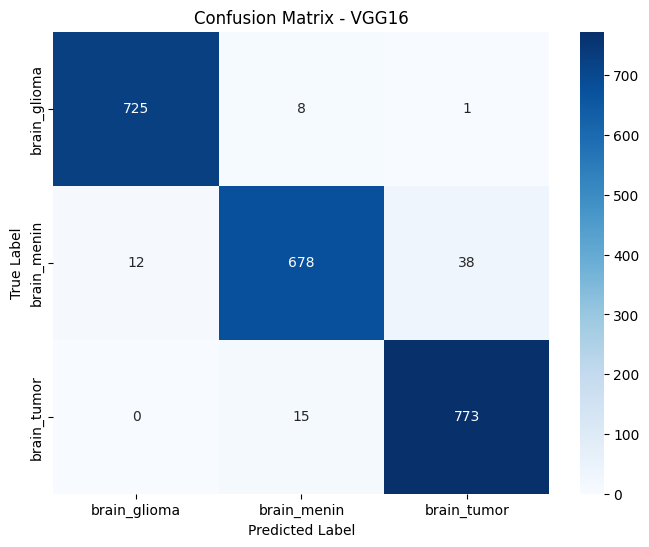


--- ROC Curve ---
Overall ROC AUC Score (OVR): 0.9972


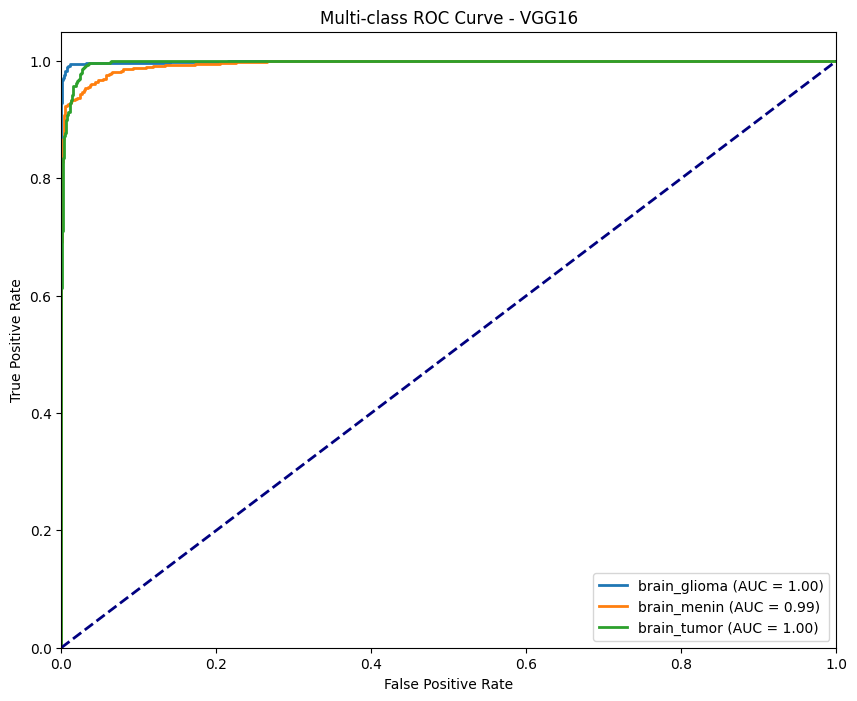


Task 2 Execution Fully Complete!


In [3]:
%matplotlib inline
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, models, transforms

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ==========================================
# 1. Setup & Configuration
# ==========================================
print("--- Step 1: Initialization ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device.type.upper()}")

# Exact path based on Kaggle directory structure
DATA_DIR = '/kaggle/input/datasets/obulisainaren/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer'
NUM_CLASSES = 3 
BATCH_SIZE = 32
NUM_EPOCHS = 50 # Required by assignment guidelines

# ==========================================
# 2. Dataset Wrapper & Transforms
# ==========================================
class DatasetWrapper(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

# Augmentation for training to prevent overfitting
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Only resizing and normalizing for Val/Test
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ==========================================
# 3. Data Loading & Splitting
# ==========================================
print("\n--- Step 2: Loading Data ---")
raw_dataset = datasets.ImageFolder(root=DATA_DIR)
class_names = raw_dataset.classes
print(f"Classes found: {class_names}")

total_size = len(raw_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_subset, val_subset, test_subset = random_split(
    raw_dataset, [train_size, val_size, test_size], 
    generator=torch.Generator().manual_seed(42)
)

train_data = DatasetWrapper(train_subset, transform=train_transforms)
val_data = DatasetWrapper(val_subset, transform=val_test_transforms)
test_data = DatasetWrapper(test_subset, transform=val_test_transforms)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataset split: {train_size} Train, {val_size} Val, {test_size} Test")

# ==========================================
# 4. Model Setup (VGG16 Transfer Learning)
# ==========================================
print("\n--- Step 3: Setting up VGG16 ---")
# Load pre-trained base
model = models.vgg16(pretrained=True)

# Freeze initial layers
for param in model.features.parameters():
    param.requires_grad = False
    
# Modify final classifier layer
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, NUM_CLASSES)
)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# ==========================================
# 5. Training Loop
# ==========================================
print(f"\n--- Step 4: Training for {NUM_EPOCHS} Epochs ---")
best_val_loss = float('inf')
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    
    # Train
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
    epoch_train_loss = running_loss / train_size
    
    # Validate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
    epoch_val_loss = val_loss / val_size
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    # Save best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_vgg16_brain.pth')
        print("  -> Best model saved!")

train_duration = time.time() - start_time
print(f"Training completed in {train_duration // 60:.0f}m {train_duration % 60:.0f}s")

# ==========================================



--- Step 5: Evaluation on Test Set ---
Running inference on test images...
Inference completed in 17.92 seconds

--- Classification Report ---
              precision    recall  f1-score   support

brain_glioma       0.98      0.99      0.99       734
 brain_menin       0.97      0.93      0.95       728
 brain_tumor       0.95      0.98      0.97       788

    accuracy                           0.97      2250
   macro avg       0.97      0.97      0.97      2250
weighted avg       0.97      0.97      0.97      2250


--- Class-wise Accuracies ---
brain_glioma: 98.77%
brain_menin: 93.13%
brain_tumor: 98.10%

--- Confusion Matrix ---


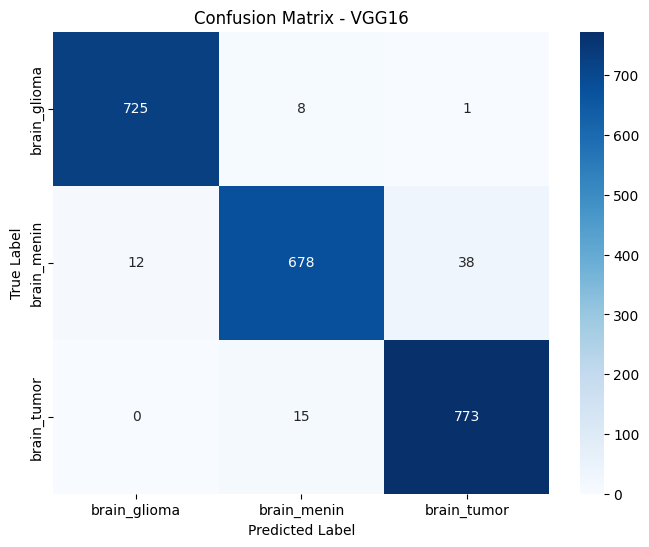


--- ROC Curve ---
Overall ROC AUC Score (OVR): 0.9972


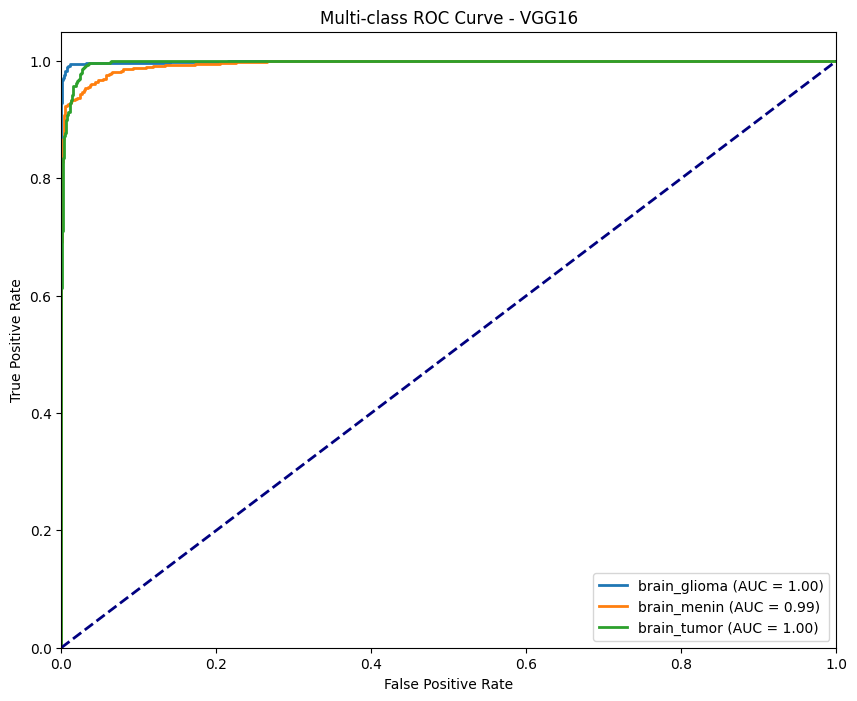


Task 2 Execution Fully Complete!


In [4]:
# 6. Evaluation & Plotting
# ==========================================
print("\n--- Step 5: Evaluation on Test Set ---")
# Load the best weights we just saved
model.load_state_dict(torch.load('best_vgg16_brain.pth'))
model.eval()

all_preds = []
all_labels = []
all_probs = []

test_start_time = time.time()
print("Running inference on test images...")

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_duration = time.time() - test_start_time
print(f"Inference completed in {test_duration:.2f} seconds")

# Metrics
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=class_names))
print("\n--- Class-wise Accuracies ---")
cm = confusion_matrix(all_labels, all_preds)
class_accuracies = cm.diagonal() / cm.sum(axis=1)

for i, class_name in enumerate(class_names):
    print(f"{class_name}: {class_accuracies[i] * 100:.2f}%")
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - VGG16')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\n--- ROC Curve ---")
labels_bin = label_binarize(all_labels, classes=[0, 1, 2])
auc_score = roc_auc_score(labels_bin, all_probs, multi_class='ovr')
print(f"Overall ROC AUC Score (OVR): {auc_score:.4f}")

plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve - VGG16')
plt.legend(loc="lower right")
plt.show()

print("\nTask 2 Execution Fully Complete!")